In [ ]:
!pwd

/content


In [ ]:
%cd '/content/drive/MyDrive/programming projects/SAM'

/content/drive/MyDrive/programming projects/SAM


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

import cv2
import torch
import requests
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from io import BytesIO
from torchvision.transforms import Compose

from depth_anything.dpt import DepthAnything
from depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

def get_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    return np.array(img)

def get_image_from_files(dir):
  images_list = list()
  for root, dirs, files in os.walk(dir):
    for file in files:
      images_list.append(dir+file)
  print(f'There are {len(images_list)} images in our dataset')
  return images_list

dir = "/content/drive/MyDrive/programming projects/SAM/dataset/"
images_list = get_image_from_files(dir)

There are 24 images in our dataset


# Obtain depth

In [ ]:
# img_url = "https://koitu.com/gallery/photos/PXL_20240118_062519789.jpg"
# img_url = "https://www.prints-online.com/p/164/exposition-universelle-internationale-paris-23439848.jpg"
# img = get_image_from_url(img_url)

raw_image = cv2.imread(dir+'snowmountain.JPG')
raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB) / 255.0

In [ ]:
encoder = 'vitb' # can also be 'vits', 'vitb' or 'vitl'

transform = Compose([
    Resize(
        width=518,
        height=518,
        resize_target=False,
        keep_aspect_ratio=True,
        ensure_multiple_of=14,
        resize_method='lower_bound',
        image_interpolation_method=cv2.INTER_CUBIC,
    ),
    NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    PrepareForNet(),
])

depth_anything = DepthAnything.from_pretrained('LiheYoung/depth_anything_{:}14'.format(encoder)).eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/113 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/390M [00:00<?, ?B/s]

In [ ]:
%%time
image_resized = transform({'image': raw_image})['image']
image_resized = torch.from_numpy(image_resized).unsqueeze(0)

depth = depth_anything(image_resized)  # depth shape: 1xHxW
depth = depth.detach().squeeze()

CPU times: user 18.7 s, sys: 2.6 s, total: 21.3 s
Wall time: 6.59 s


In [ ]:
# for img_name in images_list:
#   image = cv2.imread(img_name)
#   image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255.0

#   image_resized = transform({'image': image})['image']
#   image_resized = torch.from_numpy(image_resized).unsqueeze(0)

#   depth = depth_anything(image_resized)  # depth shape: 1xHxW
#   depth = depth.detach().numpy()
#   path = '/content/drive/MyDrive/programming projects/SAM/output/depth/'+img_name.split('.')[0].split('/')[-1]+'.npy'
#   np.save(path, depth)
#   print(path)

/content/drive/MyDrive/programming projects/SAM/output/depth/malta.npy
/content/drive/MyDrive/programming projects/SAM/output/depth/snowmountain.npy
/content/drive/MyDrive/programming projects/SAM/output/depth/nice.npy
/content/drive/MyDrive/programming projects/SAM/output/depth/morges.npy
/content/drive/MyDrive/programming projects/SAM/output/depth/snowmountain2.npy
/content/drive/MyDrive/programming projects/SAM/output/depth/spring2.npy
/content/drive/MyDrive/programming projects/SAM/output/depth/atomic-dome.npy
/content/drive/MyDrive/programming projects/SAM/output/depth/lake.npy
/content/drive/MyDrive/programming projects/SAM/output/depth/gundam.npy
/content/drive/MyDrive/programming projects/SAM/output/depth/spring.npy
/content/drive/MyDrive/programming projects/SAM/output/depth/crossing.npy
/content/drive/MyDrive/programming projects/SAM/output/depth/lotus.npy
/content/drive/MyDrive/programming projects/SAM/output/depth/flower.npy
/content/drive/MyDrive/programming projects/SAM/o

In [ ]:
depth.shape

(1, 518, 924)

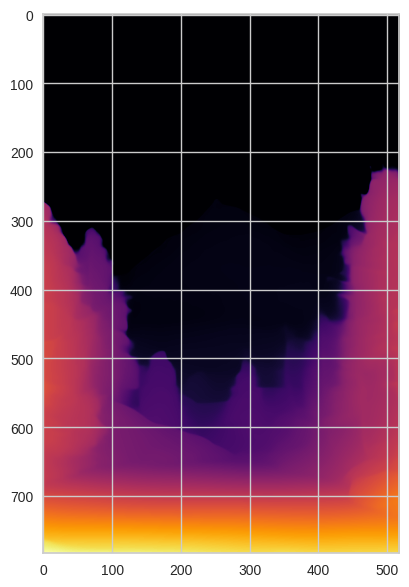

In [ ]:
plt.figure(figsize=(15,7))
plt.imshow(depth,cmap='inferno')
plt.show()

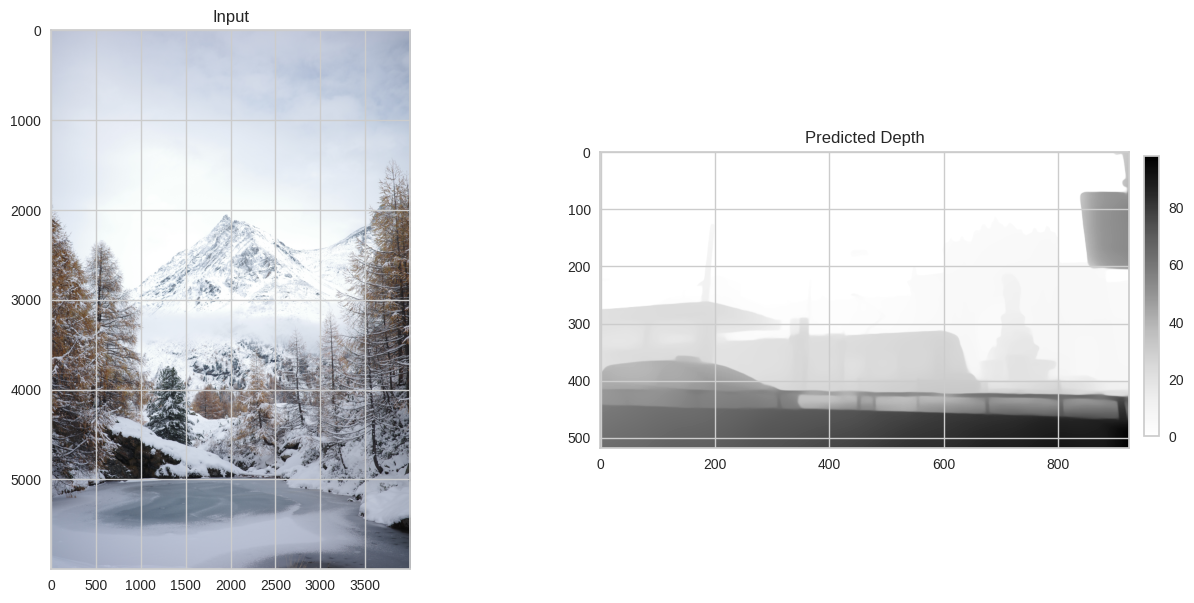

In [ ]:
plt.figure(figsize=(15,7))

plt.subplot(121)
plt.title('Input')
plt.imshow(raw_image)

plt.subplot(122)
plt.title('Predicted Depth')
plt.imshow(depth)

plt.colorbar(cax = plt.axes([0.91, 0.3, 0.01, 0.4]))

# Clustering

In [ ]:
d = depth.numpy()
n, m = np.shape(d)

d = np.reshape(d, (n*m, 1))

## Find the optimal number of clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

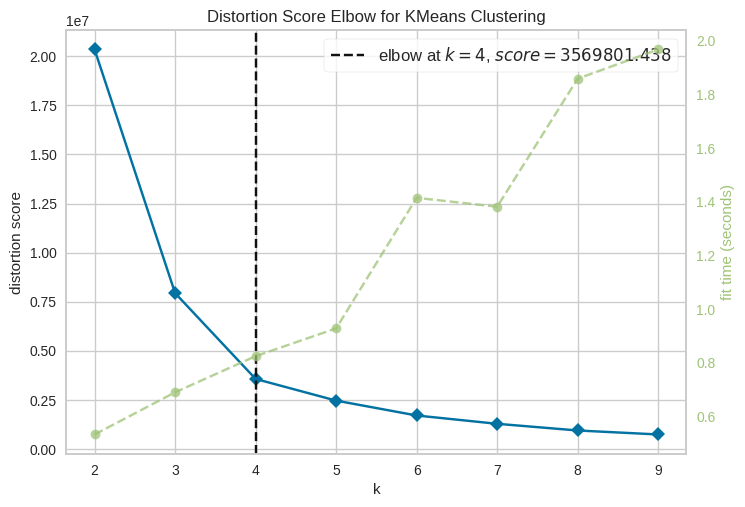

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# initialize KMeans model
model = KMeans(random_state=42)

# Initialize KElbowVisualizer, set k in the range 2 to 10
visualizer = KElbowVisualizer(model, k=(2,10))

# Fitting data and plotting elbows
visualizer.fit(d)
visualizer.show()

## Kmeans

In [ ]:
n_clusters = visualizer.elbow_value_

k_means = KMeans(n_clusters=n_clusters, random_state=42)
k_means.fit(d)
res = k_means.predict(d)
res = np.reshape(res, (n,m))

# Used to store the cluster center value corresponding to each data point
res_clusters = k_means.labels_
res_labels = np.reshape(res_clusters, (n,m)).astype(np.float64)
res_centers = k_means.cluster_centers_[k_means.labels_]
res_depth = np.reshape(res_centers, (n,m))

# Upsample the segmented depth image
original_height, original_width = raw_image.shape[:2]
res_depth_upsampled = cv2.resize(res_depth, (original_width, original_height), interpolation=cv2.INTER_CUBIC)
res_labels_upsampled = cv2.resize(res_labels, (original_width, original_height), interpolation=cv2.INTER_CUBIC)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


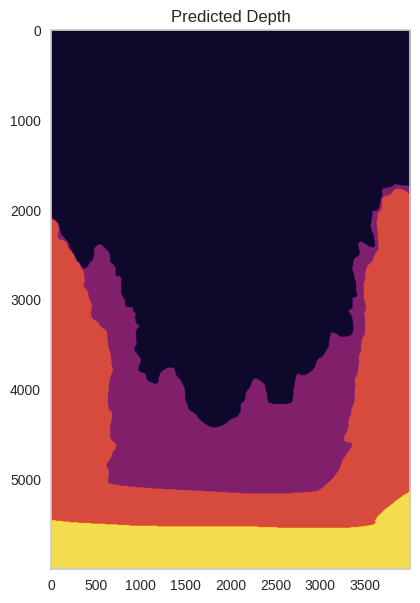

In [ ]:
plt.figure(figsize=(15,7))
plt.title('Predicted Depth')
plt.grid(False)
plt.imshow(res_depth_upsampled, cmap='inferno')

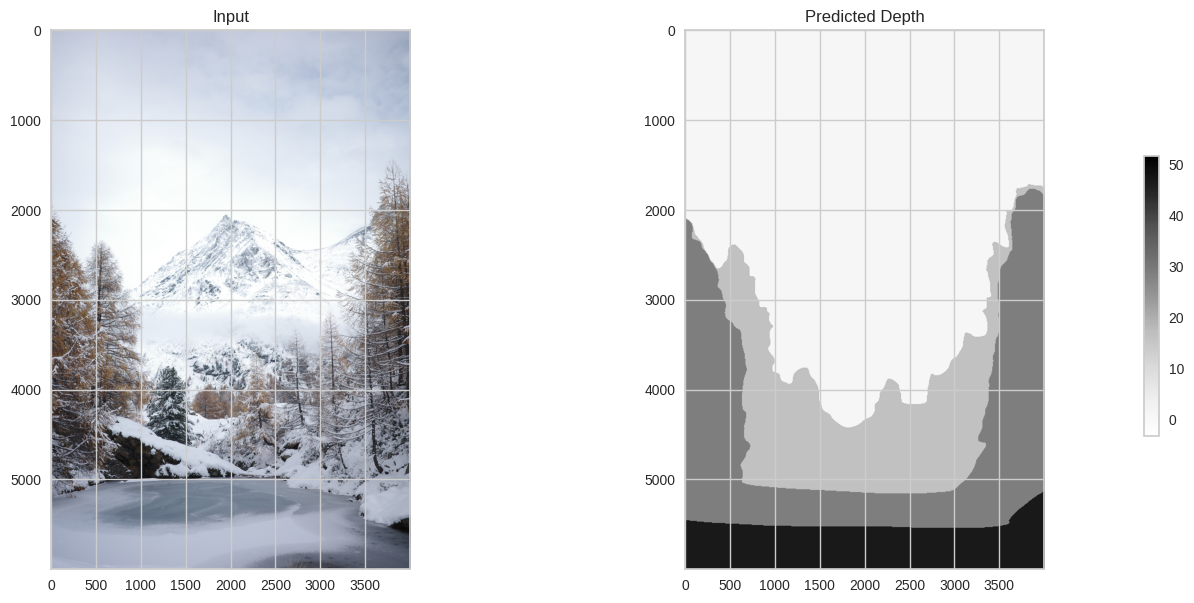

In [ ]:
plt.figure(figsize=(15,7))

plt.subplot(121)
plt.title('Input')
plt.imshow(raw_image)

plt.subplot(122)
plt.title('Predicted Depth')
plt.imshow(res_depth_upsampled)

plt.colorbar(cax = plt.axes([0.91, 0.3, 0.01, 0.4]))

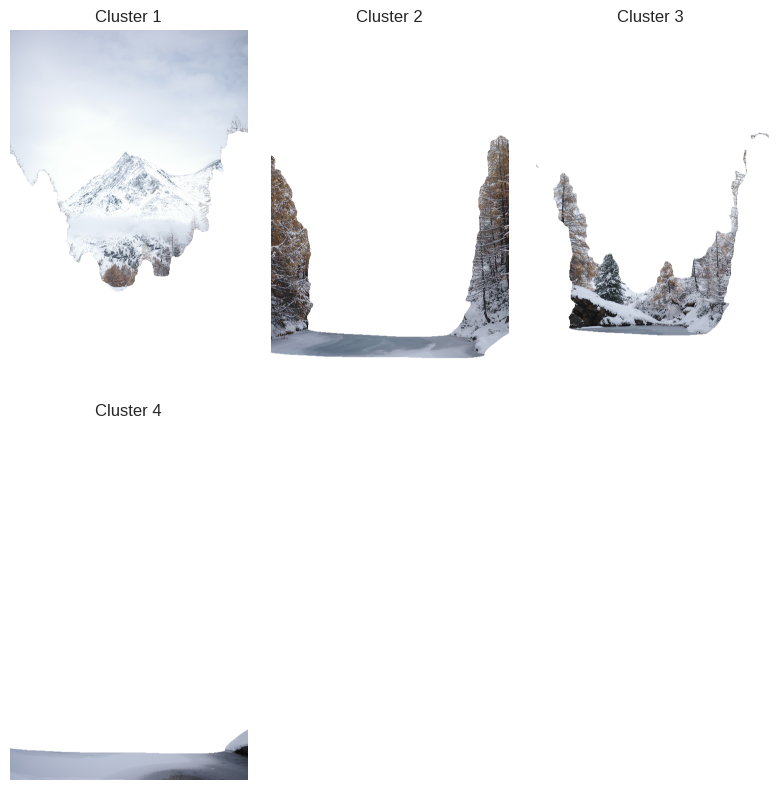

In [ ]:
plt.figure(figsize=(8,12))
rows = (n_clusters + 1 + 1) // 2


# Display the original img
# plt.subplot(rows, 2, 1)
# plt.title('Original Image')
# plt.imshow(raw_image)
# plt.axis('off')

for i in range(n_clusters):
    # Create a background the same size as the original image but with all pixels white
    cluster_img = np.ones_like(raw_image)

    # Find the pixel points that belong to the current cluster
    # and set the color of these points to the color in the original image
    mask = res_labels_upsampled == i
    mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
    cluster_img[mask] = raw_image[mask]

    plt.subplot(rows, 3, i + 1)
    plt.title(f'Cluster {i + 1}')
    plt.imshow(cluster_img)
    plt.axis('off')

plt.tight_layout()
plt.show()


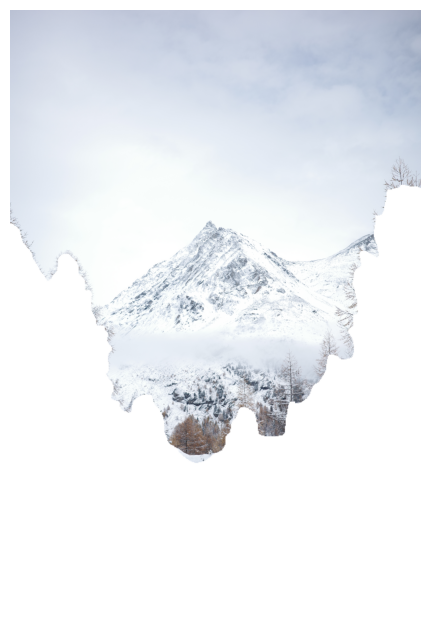

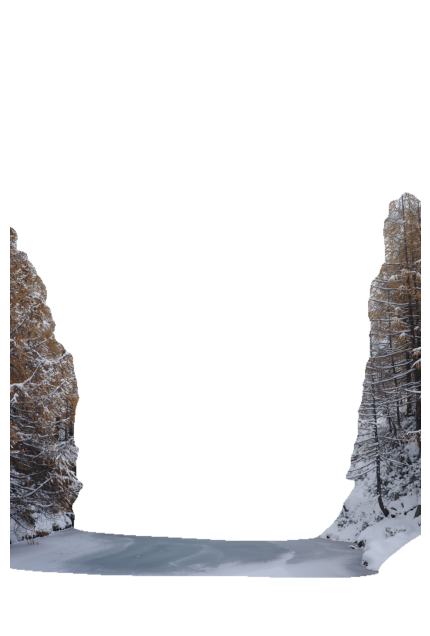

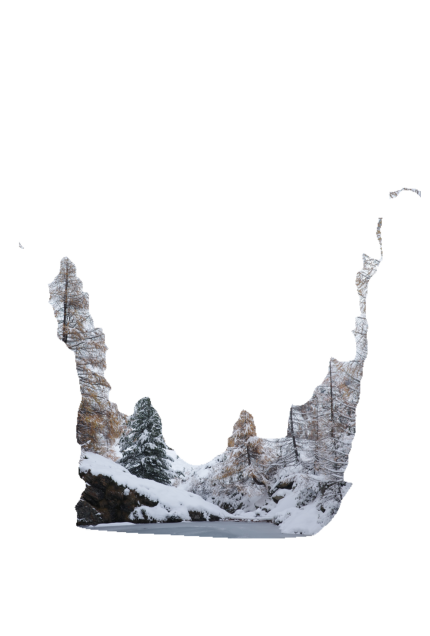

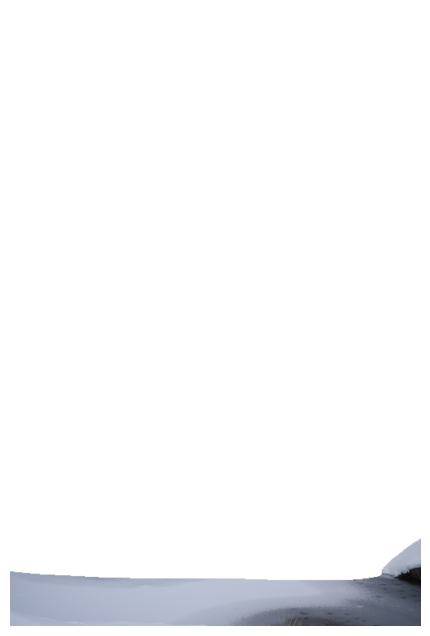

In [ ]:
for i in range(n_clusters):
    cluster_img = np.ones_like(raw_image)

    mask = res_labels_upsampled == i
    mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
    cluster_img[mask] = raw_image[mask]

    plt.figure(figsize=(10, 8))
    plt.imshow(cluster_img)
    # plt.title(f'Cluster {i + 1}')
    plt.axis('off')
    plt.show()

    plt.imsave(f'Cluster_{i + 1}.png', cluster_img, format='png')